In [3]:
from dataclasses import dataclass
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

from tensorflow.keras import layers
from tensorflow.keras.losses import MeanAbsolutePercentageError
from tensorflow import keras
from json import loads
import pandas as pd

## Sonnleiter ODE

In [4]:
@dataclass
class Params:
    ks:float
    ke:float
    ko:float
    Ks:float
    Ke:float
    Ko:float
    Ki:float
    a1:float
    a3:float
    b1:float
    b2:float
    b3:float
    Sin:float
    Ein:float
    O2in:float
    d2:float
    kla:float
    O2star:float

@dataclass
class Input:
    u:list
    t:list

In [5]:
def sonnleitner_ode(t:float, x:list, p:Params, u:Input):
    """
    Function: sonnleitner_ode

    Description:
        Defines the right-hand side of Sonnleitner's bottleneck model
        for yeast fermentation.

    Parameters:
        t (float): Time.
        x (list or np.ndarray): State vector [B, S, E, O2].
        p (object): Object containing model parameters with attributes 
                    ks, Ke, Ko, Ki, a1, a3, b1, b2, b3, Sin, Ein, O2in, kla, O2star.
        u (object): Object containing input function (u.u) and time vector (u.t).

    Returns:
        np.ndarray: Right-hand side of model equations [Bdot, Sdot, Edot, O2dot].
    """

    # Assignments for improved readability
    B, S, E, O2 = x

    # Sonnleitner model
    rs = p.ks * S / (S + p.Ks)
    re = p.ke * E / (E + p.Ke)
    ro = p.ko * O2 / (O2 + p.Ko) * (p.Ki / (p.Ki + E))

    r1 = min(rs, ro / p.a1)
    r2 = max(0, rs - ro / p.a1)
    r3 = max(0, min(re, (ro - p.a1 * rs) / p.a3))

    # Dilution rate
    D = interp1d(u.t, u.u, fill_value="extrapolate")(t)

    # Balance equations
    Bdot = -D * B + (p.b1 * r1 + p.b2 * r2 + p.b3 * r3) * B
    Sdot = D * (p.Sin - S) - (r1 + r2) * B
    Edot = D * (p.Ein - E) + (p.d2 * r2 - r3) * B
    O2dot = D * (p.O2in - O2) + p.kla * (p.O2star - O2) - (p.a1 * r1 + p.a3 * r3) * B

    return np.array([Bdot, Sdot, Edot, O2dot])


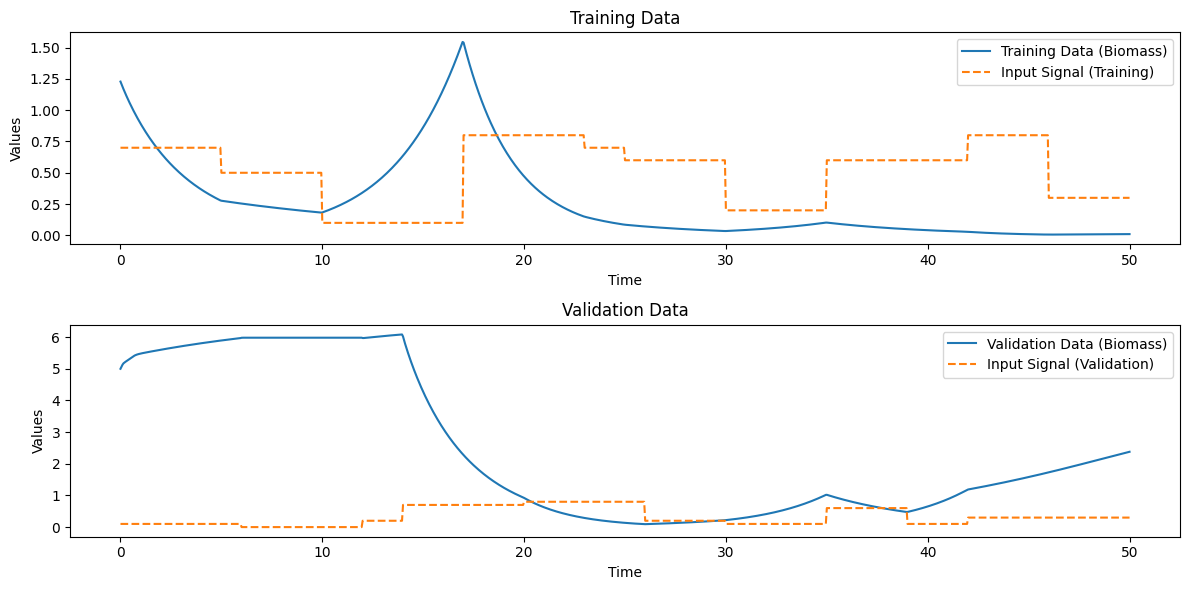

In [6]:
def stepfun(t, step_time):
    """Step function for generating piecewise input signals."""
    return np.heaviside(t - step_time, 1)

# ------------------------------------------------------------------
# Generate data using Sonnleitner's model of yeast fermentation
#
# Model states:
#   Biomass   B  = x[0]
#   Substrate S  = x[1]
#   Ethanol   E  = x[2]
#   Oxygen   O2  = x[3]

# Get model parameters (returns instance of Params class)
p = Params(**loads(open("/home/matthias/WS_all/dbm/raw/ex6_handout/params.json","r").read()))

# *****************************
# 1. Training data set

# Set input values (open-loop)
t = np.linspace(0, 50, 1001)
u1 = Input(
    t=t,
    u=0.7 - 0.2 * stepfun(t, 5) - 0.4 * stepfun(t, 10) + 0.7 * stepfun(t, 17)
        - 0.1 * stepfun(t, 23) - 0.1 * stepfun(t, 25) - 0.4 * stepfun(t, 30)
        + 0.4 * stepfun(t, 35) + 0.2 * stepfun(t, 42) - 0.5 * stepfun(t, 46)
)

# Solve differential equations
tspan = t
x0l = np.array([0.0, 0.0, 0.0, 0.0])
x0u = np.array([10.0, 1.0, 5.0, 1e-2])
dimx = len(x0l)
x0 = x0l + np.diag(x0u - x0l) @ np.random.rand(dimx)

sol1 = solve_ivp(
    lambda t, x: sonnleitner_ode(t, x, p, u1),
    t_span=(tspan[0], tspan[-1]),
    y0=x0,
    t_eval=tspan
)

tsim1, x1 = sol1.t, sol1.y.T

# Measurement data
ytrain = x1[:, 0]  # Biomass
utrain = u1.u

# *****************************
# 2. Validation data set
u2 = Input(
    t=t,
    u=0.1 - 0.1 * stepfun(t, 6) + 0.2 * stepfun(t, 12) + 0.5 * stepfun(t, 14)
        + 0.1 * stepfun(t, 20) - 0.6 * stepfun(t, 26) - 0.1 * stepfun(t, 30)
        + 0.5 * stepfun(t, 35) - 0.5 * stepfun(t, 39) + 0.2 * stepfun(t, 42)
)

x0 = x0l + np.diag(x0u - x0l) @ np.array([0.5, 0.6, 0.0, 0.4])

sol2 = solve_ivp(
    lambda t, x: sonnleitner_ode(t, x, p, u2),
    t_span=(tspan[0], tspan[-1]),
    y0=x0,
    t_eval=tspan
)

tsim2, x2 = sol2.t, sol2.y.T

# Measurement data
ytest = x2[:, 0]  # Biomass
utest = u2.u

# ------------------------------------------------------------------
# Sampling time
Ts = np.mean(np.diff(t))

# ------------------------------------------------------------------
# Placeholder for ARX and nonlinear ARX model setup
# Since MATLAB functions like `iddata`, `arx`, `compare`, `predict`, and `nlarx`
# are not available in Python, you would need to use libraries like `statsmodels`,
# `torch` or `tensorflow` to implement equivalent functionalities.

# For now, let's plot the data as a visual verification
plt.figure(figsize=(12, 6))

# Training data
plt.subplot(2, 1, 1)
plt.plot(tsim1, ytrain, label="Training Data (Biomass)")
plt.plot(tsim1, utrain, label="Input Signal (Training)", linestyle='--')
plt.legend()
plt.title("Training Data")
plt.xlabel("Time")
plt.ylabel("Values")

# Validation data
plt.subplot(2, 1, 2)
plt.plot(tsim2, ytest, label="Validation Data (Biomass)")
plt.plot(tsim2, utest, label="Input Signal (Validation)", linestyle='--')
plt.legend()
plt.title("Validation Data")
plt.xlabel("Time")
plt.ylabel("Values")

plt.tight_layout()
plt.show()




In [31]:
in_ = layers.Input(shape=(1,2))
x = layers.LSTM(16)(in_)
x = layers.Dense(16, activation='relu')(x)
out = layers.Dense(1)(x)

model = keras.Model(inputs=in_, outputs=out)

In [32]:
model.compile(optimizer='sgd', loss="mae", metrics=['mae'])

u_train = [(i * Ts, u) for i, u in enumerate(utrain)]
u_train = np.array(u_train).reshape(-1, 1, 2)
y_train = np.array(ytrain).reshape(-1, 1)

history = model.fit(x=u_train, y=y_train, epochs=50)

Epoch 1/50


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2350 - mae: 0.2350
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2098 - mae: 0.2098
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2107 - mae: 0.2107
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2119 - mae: 0.2119
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1949 - mae: 0.1949
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2109 - mae: 0.2109
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1669 - mae: 0.1669
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1685 - mae: 0.1685
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1751 - mae: 0.1751
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1683 - mae: 0.1683
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1686 - mae: 0.1686
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1717 - mae: 0.1717
Epoch 13/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0

In [33]:
u_test = [(i * Ts, u) for i, u in enumerate(utest)]
u_test = np.array(u_test).reshape(-1, 1, 2)

y_pred = model.predict(u_train).flatten()

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


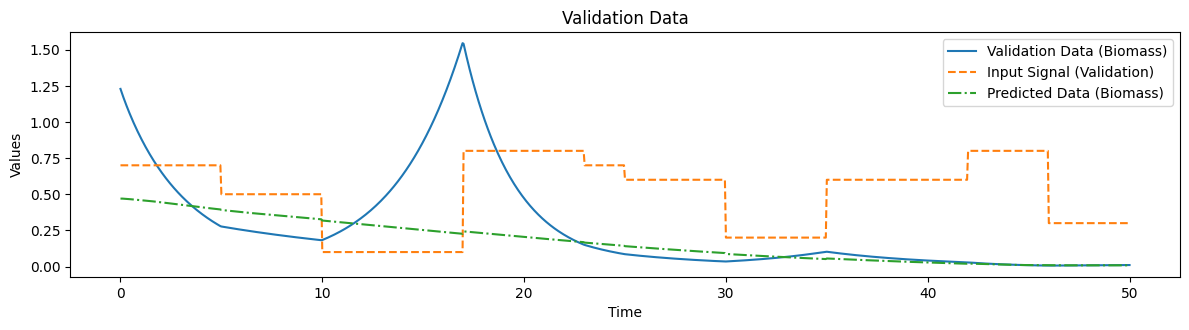

In [34]:
# For now, let's plot the data as a visual verification
plt.figure(figsize=(12, 6))

# Validation data
plt.subplot(2, 1, 2)
plt.plot(tsim2, ytrain, label="Validation Data (Biomass)")
plt.plot(tsim2, utrain, label="Input Signal (Validation)", linestyle='--')
plt.plot(tsim2, y_pred, label="Predicted Data (Biomass)", linestyle='-.')
plt.legend()
plt.title("Validation Data")
plt.xlabel("Time")
plt.ylabel("Values")

plt.tight_layout()
plt.show()
